## Purpose
1. To understand mechanisms for encoding inputs with good information efficiency.

## Perceived Advantages
1. The encoding can represent various features of the input which are easier to analyse
2. The encoding can be used for further tasks
3. It can be used for dimensionality reduction if the encoding has fewer dimensions than input
4. The decoder can be used for generating samples.

## Theory and Motivation
To learn functions E and D s.t Z = E(X),Y = D(Z) dist(Y,X) is minimum. If Z has fewer dimensions than X then the learned functions are expected to learn the most relevant features of the input.
If Z has more dimensions than X then the system is said to be overcomplete and the learned functions have the risk of being identity functions which overfit the training set and doesnt capture input characteristics. In this work we will analyse both undercomplete and overcomplete systems.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as tfunc
from torch.utils.data import dataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import seaborn as sns
sys.path.append('../')
%matplotlib inline

In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(10,(0.02,0.02)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])


mnist_X = torchvision.datasets.MNIST("./mnist",train=True,download=True,transform=train_transforms)
mnist_length = mnist_X.__len__()
mnist_train,mnist_val = dataset.random_split(mnist_X,[int(0.9*mnist_length),mnist_length-int(0.9*mnist_length)])
mnist_test = torchvision.datasets.MNIST("./mnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

fmnist_X = torchvision.datasets.FashionMNIST("./fmnist",train=True,download=True,transform=train_transforms)
fmnist_length = fmnist_X.__len__()
fmnist_train,fmnist_val = dataset.random_split(fmnist_X,[int(0.9*fmnist_length),fmnist_length-int(0.9*fmnist_length)])
fmnist_test = torchvision.datasets.FashionMNIST("./fmnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

emnist_X = torchvision.datasets.EMNIST("./emnist",split='balanced',train=True,download=True,transform=train_transforms)
emnist_length = emnist_X.__len__()
emnist_train,emnist_val = dataset.random_split(emnist_X,[int(0.9*emnist_length),emnist_length-int(0.9*emnist_length)])
emnist_test = torchvision.datasets.EMNIST("./emnist",split='balanced',train=False,download=True,transform=torchvision.transforms.ToTensor())



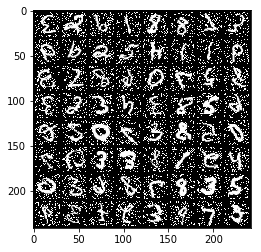

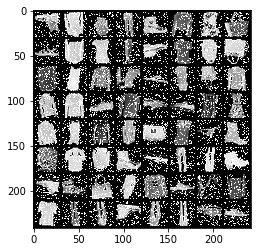

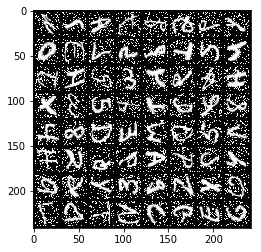

In [3]:
def plt_image(inp) :
    inp = torchvision.utils.make_grid(inp)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
def imshow(dataset) :
    inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)))
    inp = inp+torch.ge(torch.randn_like(inp),1.).type_as(inp)
    inp = torch.clamp(inp,0,1)
    plt_image(inp)
    
imshow(mnist_train)
imshow(fmnist_train)
imshow(emnist_train)

In [4]:
import torch.optim as optim
def train(encoder,decoder,dataset,loss_fn,lr) :
    optimizer_enc = optim.Adam(encoder.parameters(),lr)
    optimizer_dec = optim.Adam(decoder.parameters(),lr)
    encoder.train()
    decoder.train()
    for x,_ in dataset :
        x = x.cuda()
        z = encoder(x)
        y = decoder(z)
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()        
        loss_fn(x,y,z).mean().backward()
        optimizer_enc.step()
        optimizer_dec.step()
        

def inference(encoder,decoder,dataset,loss_fn) :
    loss = 0
    with torch.no_grad() :
        encoder.eval()
        decoder.eval()
        for x,_ in dataset :
            x  = x.cuda()
            z = encoder(x)
            y = decoder(z)
            loss += loss_fn(x,y,z).sum().item()
    return loss/dataset.dataset.__len__()

def run_epoch(encoder,decoder,lr,batch_size,loss_fn,train_dataset,val_dataset,test_dataset,max_epochs) :
    train_losses = []
    val_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=False,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=batch_size)

    for i in range(max_epochs+1) :
        train(encoder,decoder,train_loader,loss_fn,lr)
        if i%10 == 0 :
            train_losses.append(inference(encoder,decoder,train_loader,loss_fn))
            val_losses.append(inference(encoder,decoder,val_loader,loss_fn))
            test_losses.append(inference(encoder,decoder,test_loader,loss_fn))
            print("Epoch {}: {} {} {}".format(i,train_losses[-1],val_losses[-1],test_losses[-1]))
    return train_losses,val_losses,test_losses
       

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self,latent_dims,final_dims):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(latent_dims,final_dims,bias=False)
        )
    def forward(self, x):
        x= x.view(x.shape[0],-1)
        x = torch.sigmoid(self.decode(x))
        return x
    
    
class Encoder(torch.nn.Module):
    def __init__(self,inp_dims,latent_dims):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(inp_dims,latent_dims),
        )
    def forward(self, x, flag=True):
        x= x.view(x.shape[0],-1)
        x = torch.clamp(x + torch.ge(torch.randn_like(x),1.).type_as(x),0.,1.)
        x  = torch.tanh(self.encode(x))
        return x


In [14]:
def reconstruction_loss(x,y,z) :
    x = x.view(x.shape[0],-1).type_as(z)
    y = y.view(x.shape[0],-1)
    z = z.view(x.shape[0],-1)
    inter = (x*y).sum(dim=1)
    union = (x+y).sum(dim=1)
    return 1 - (2*inter/union)



In [ ]:
def get_encodings(encoder,dataset,batch_size) :
    torch.cuda.empty_cache()
    encoding = []
    loader = torch.utils.data.DataLoader(dataset,shuffle=False,batch_size=batch_size)
    with torch.no_grad() :
        encoder.eval()
        for x,_ in loader :
            x  = x.cuda()
            z = encoder(x).cpu().numpy()
            encoding.append(z)
    return np.vstack(encoding)

def analyse_encoding(decoder,encodings,batch_size) :
    encodings_dev = np.std(encodings,axis=0)
    plt.plot(encodings_dev)
    plt.title("deviation plots")
    plt.show()

    torch.cuda.empty_cache()
    dataset = torch.utils.data.TensorDataset(torch.tensor(encodings.astype(np.float32)))
    loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size)
    with torch.no_grad() :
        decoder.eval()
        z = next(iter(loader))[0].numpy()
        y = decoder(torch.Tensor(z).cuda()).cpu().view(z.shape[0],1,28,28)
        plt_image(y)
        for i in range(0,z.shape[1],20) :
            mask = np.ones([1,z.shape[1]])
            mask[0,i] = 0
            vals = np.linspace(-1,1,10) 
            for val in  vals :
                copy = z*mask + mask*val
                y = decoder(torch.Tensor(copy).cuda()).cpu().view(z.shape[0],1,28,28)
                plt_image(y)
            print("Plotted feature ",i)

Epoch 0: 0.5047019468236853 0.5053366216023764 0.4925384092330933
Epoch 10: 0.18902836257440073 0.1896403435866038 0.17598449256420134
Epoch 20: 0.17620014676341303 0.17631323552131653 0.16444820091724396
Epoch 30: 0.1713037596631933 0.17124337275822957 0.16017321172952653
Epoch 40: 0.16864847852565623 0.1687666404247284 0.15740086023807526
Epoch 50: 0.1668452364956891 0.16689554540316265 0.1563222481250763
Epoch 60: 0.16574297445791739 0.1658916602929433 0.15514242537021636
Epoch 70: 0.16508560490608215 0.1648212287425995 0.15477895084619522
Epoch 80: 0.16420468517586037 0.16429840628306072 0.15373709168434144
Epoch 90: 0.16372682428359986 0.16344597323735555 0.15342272062301635
Epoch 100: 0.16302179034550984 0.16320954179763794 0.1530764153599739
Epoch 110: 0.16267609112351028 0.16271821864446004 0.1527555011034012
Epoch 120: 0.1623347267486431 0.16268491697311402 0.1524349690437317
Epoch 130: 0.16208623260921903 0.16202762269973756 0.1522780040025711
Epoch 140: 0.16168501292334664 0

Text(0.5,0,'epochs//10')

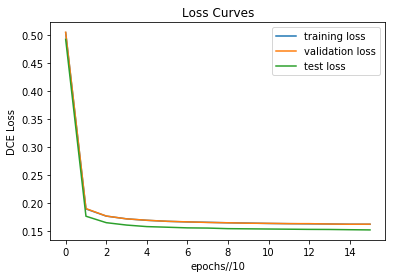

In [7]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
mnist_net_decoder = Decoder(1024,28*28).cuda()
mnist_net_encoder = Encoder(28*28,1024).cuda()
tl,vl,tel = run_epoch(mnist_net_encoder,mnist_net_decoder,1e-4,64,reconstruction_loss,mnist_train,mnist_val,mnist_test,150)
torch.save(mnist_net_decoder.state_dict(),'mnist_net_dec.mod')
torch.save(mnist_net_encoder.state_dict(),'mnist_net_enc.mod')
plt.plot(tl)
plt.plot(vl)
plt.plot(tel)
plt.legend(["training loss","validation loss","test loss"])
plt.title("Loss Curves")
plt.ylabel("DCE Loss")
plt.xlabel("epochs//10")

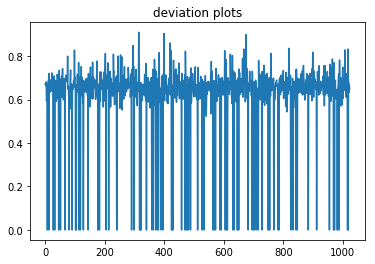

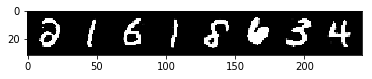

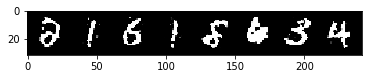

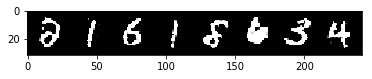

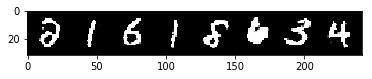

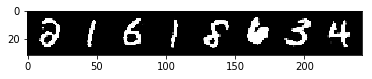

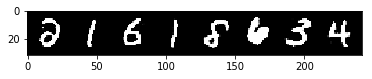

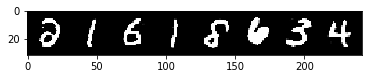

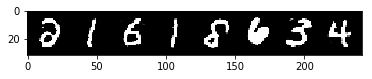

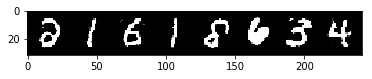

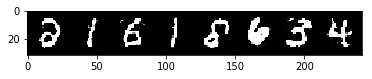

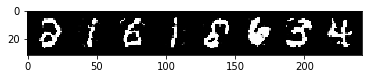

Plotted feature  0


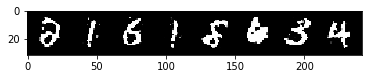

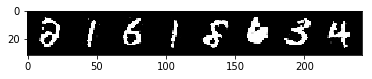

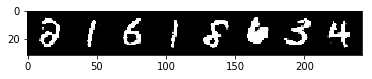

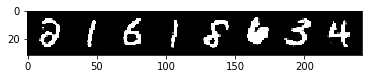

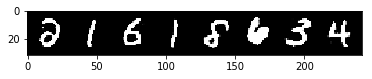

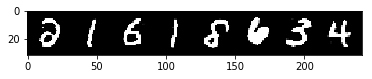

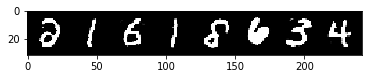

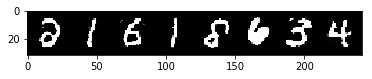

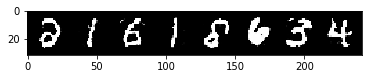

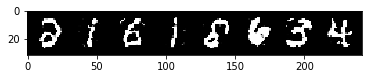

Plotted feature  20


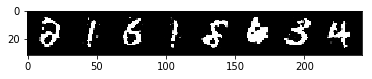

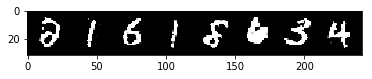

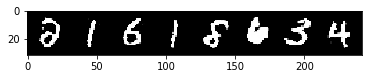

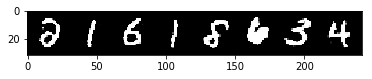

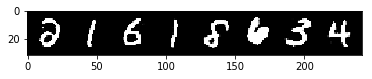

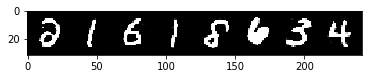

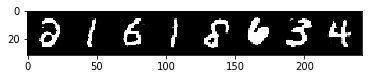

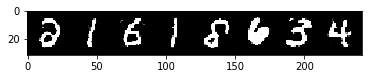

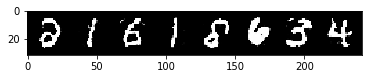

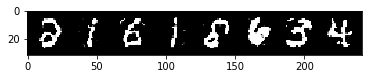

Plotted feature  40


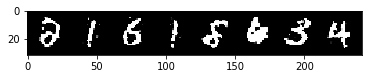

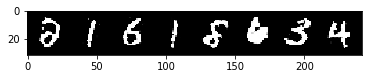

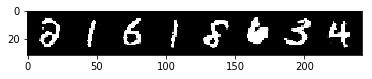

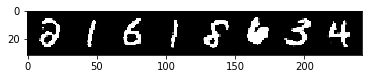

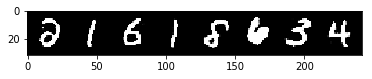

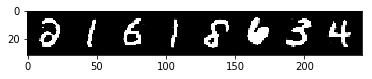

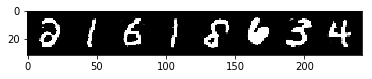

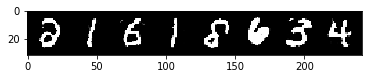

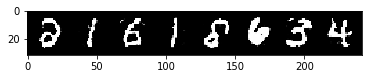

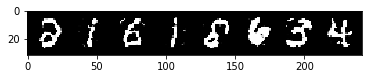

Plotted feature  60


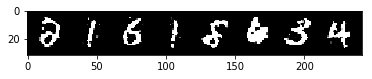

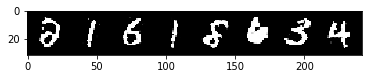

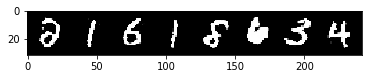

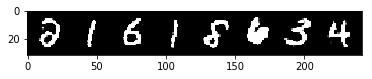

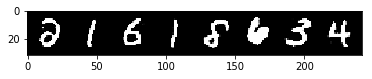

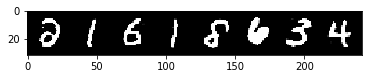

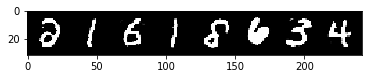

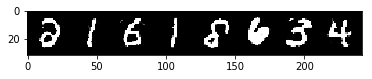

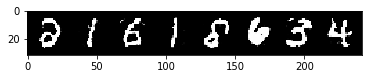

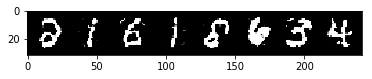

Plotted feature  80


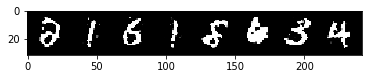

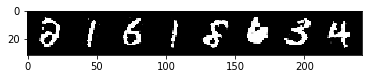

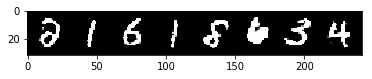

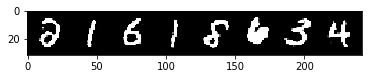

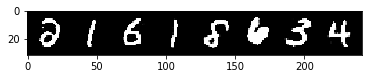

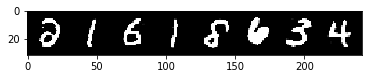

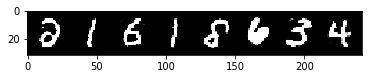

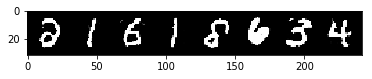

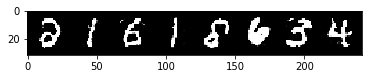

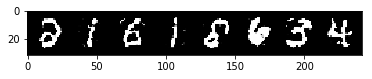

Plotted feature  100


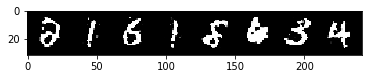

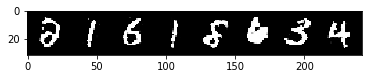

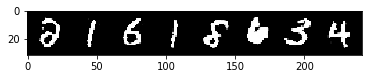

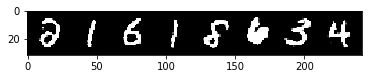

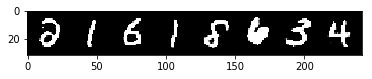

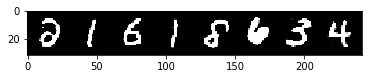

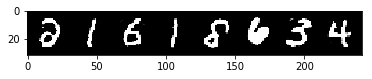

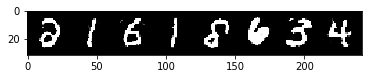

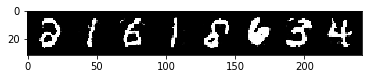

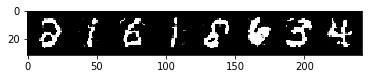

Plotted feature  120


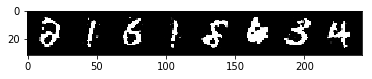

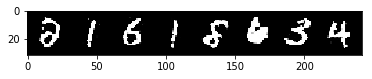

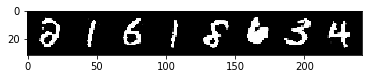

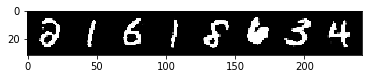

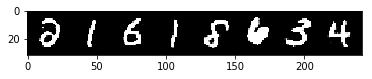

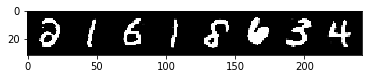

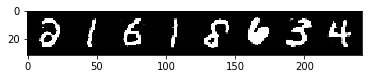

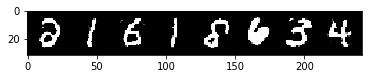

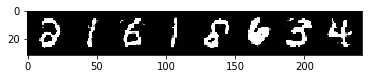

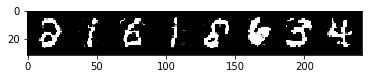

Plotted feature  140


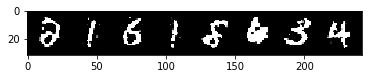

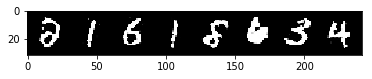

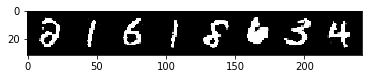

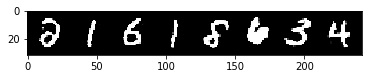

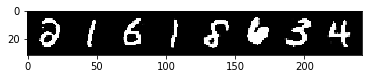

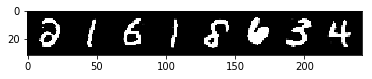

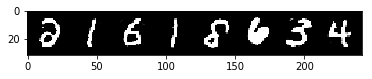

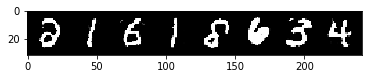

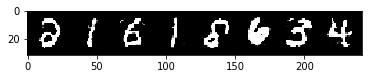

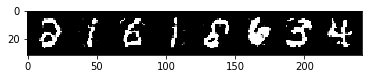

Plotted feature  160


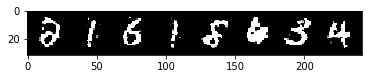

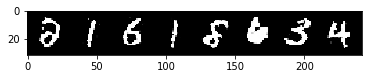

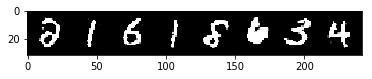

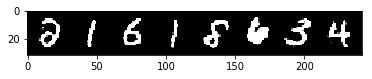

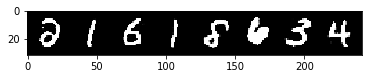

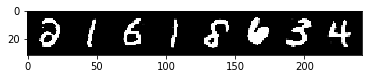

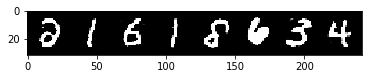

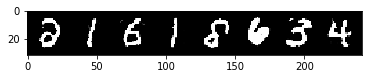

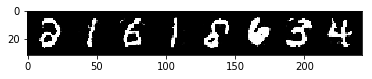

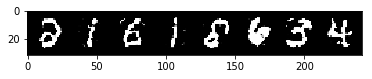

Plotted feature  180


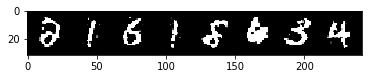

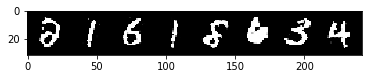

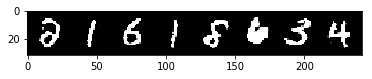

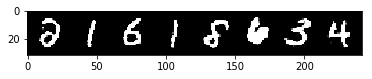

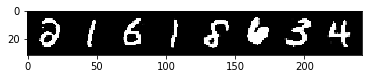

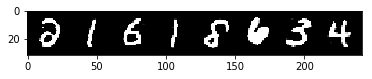

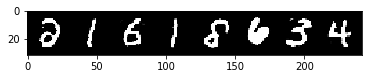

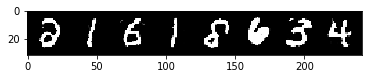

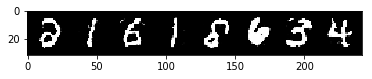

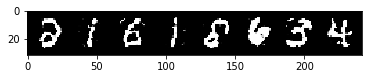

Plotted feature  200


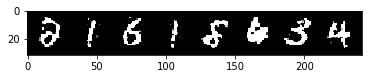

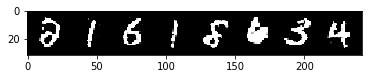

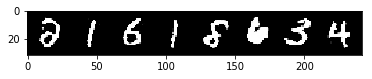

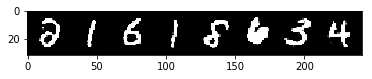

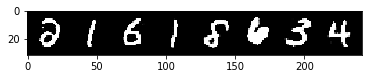

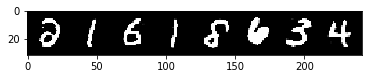

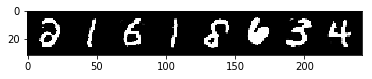

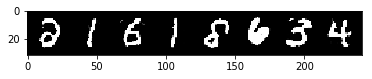

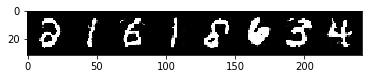

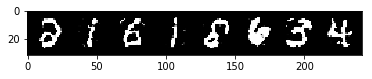

Plotted feature  220


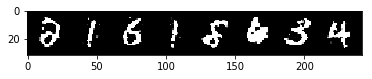

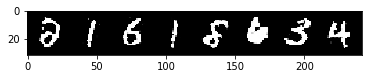

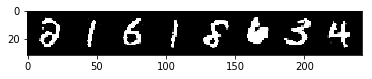

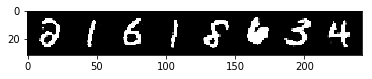

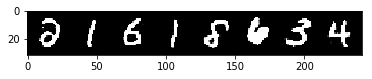

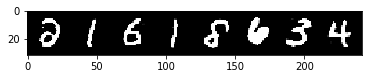

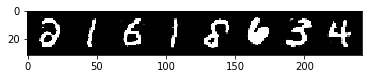

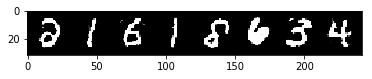

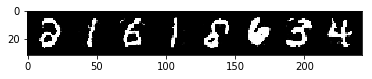

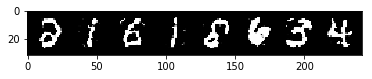

Plotted feature  240


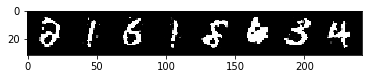

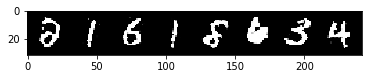

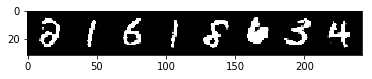

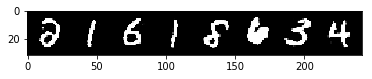

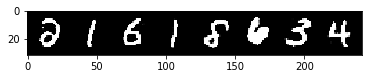

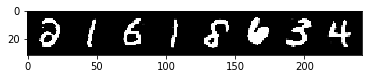

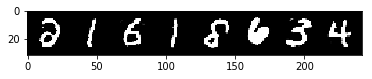

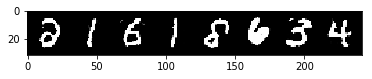

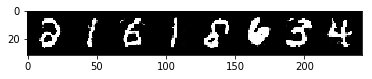

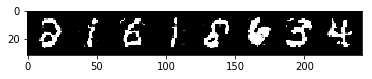

Plotted feature  260


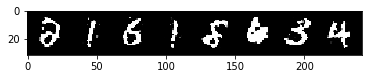

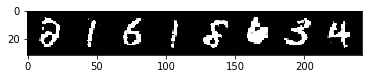

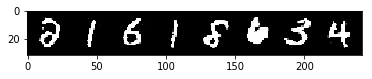

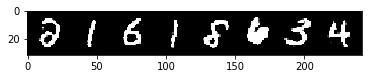

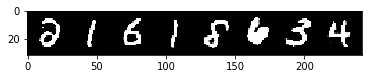

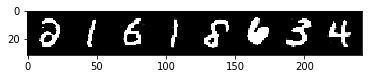

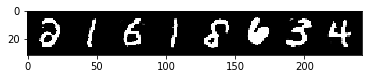

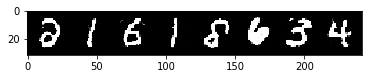

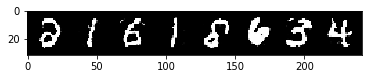

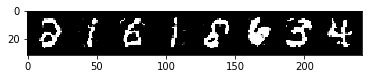

Plotted feature  280


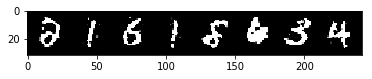

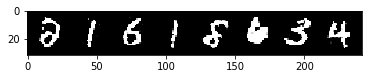

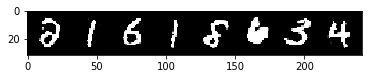

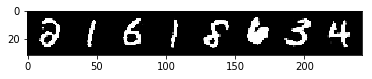

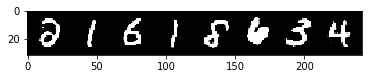

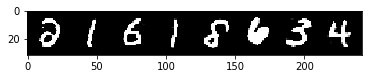

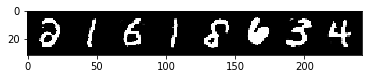

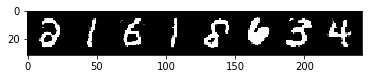

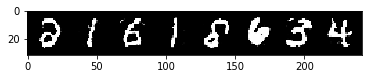

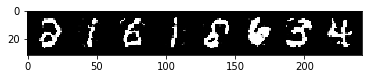

Plotted feature  300


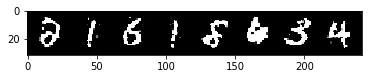

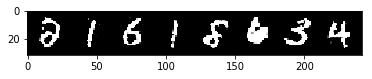

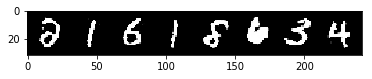

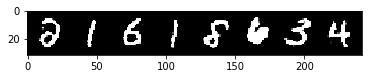

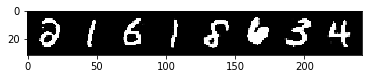

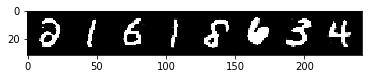

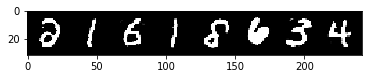

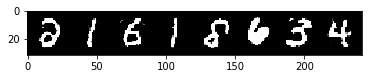

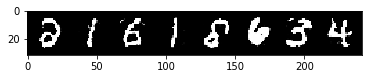

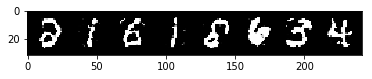

Plotted feature  320


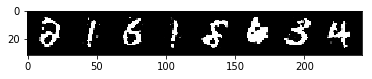

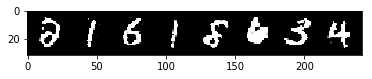

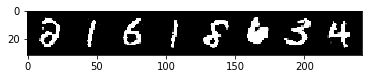

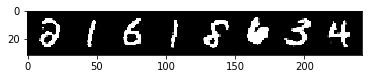

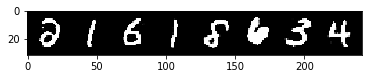

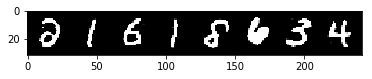

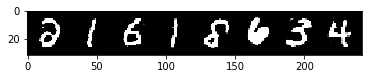

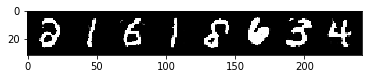

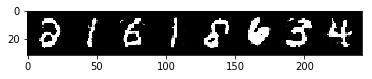

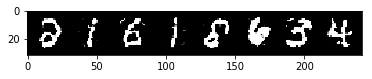

Plotted feature  340


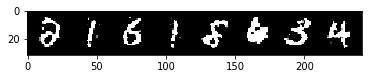

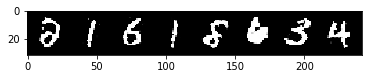

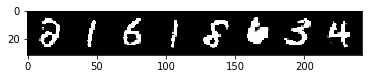

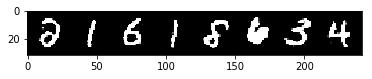

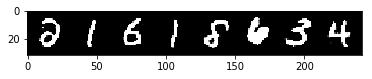

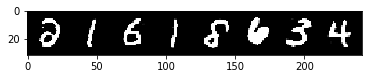

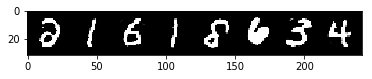

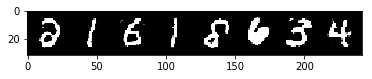

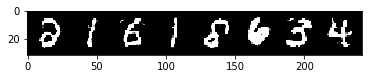

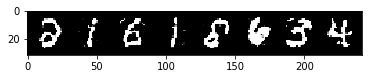

Plotted feature  360


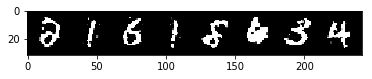

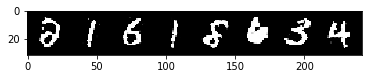

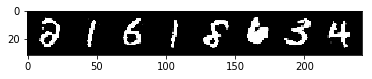

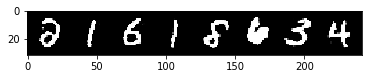

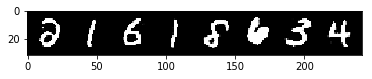

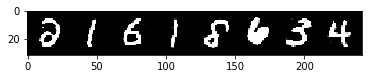

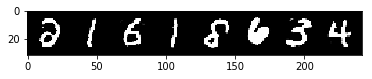

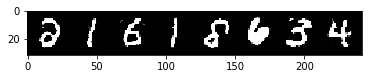

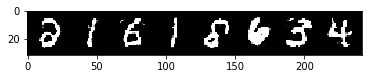

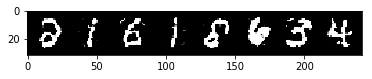

Plotted feature  380


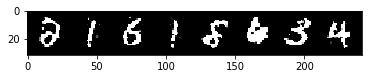

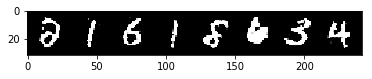

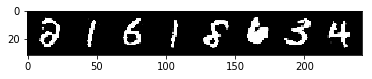

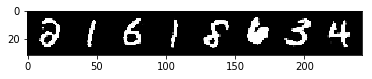

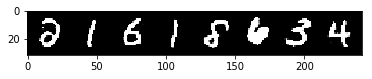

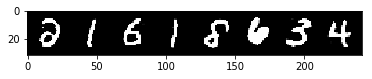

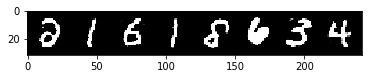

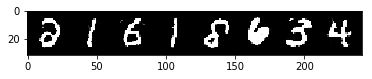

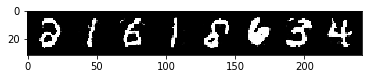

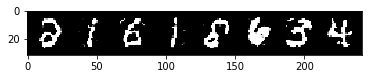

Plotted feature  400


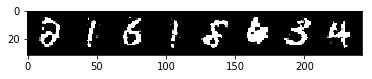

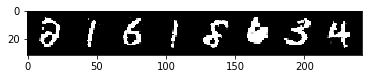

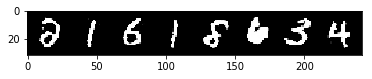

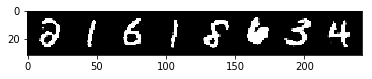

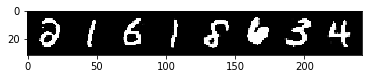

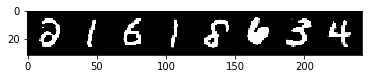

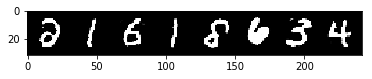

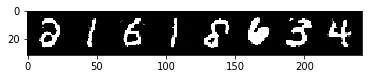

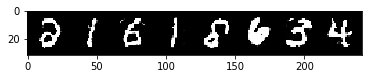

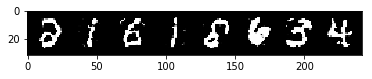

Plotted feature  420


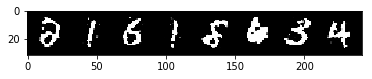

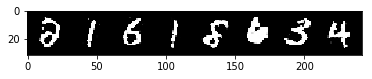

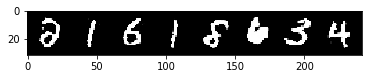

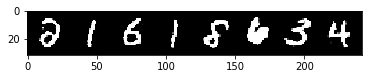

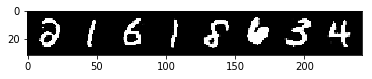

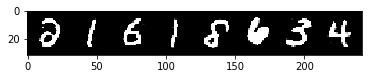

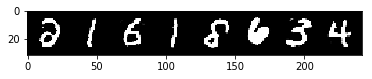

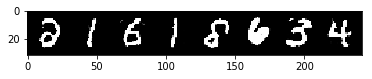

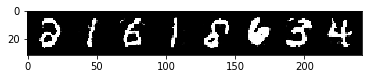

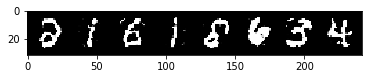

Plotted feature  440


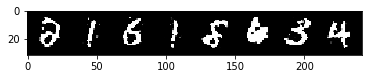

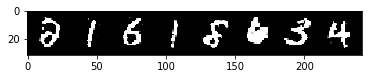

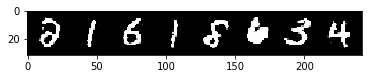

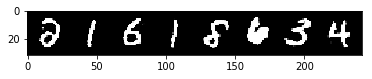

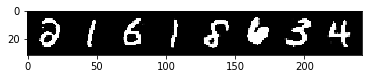

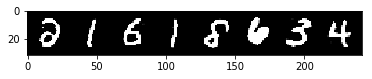

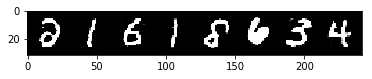

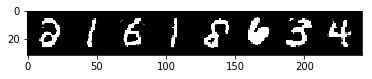

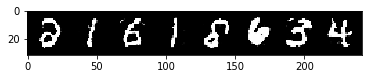

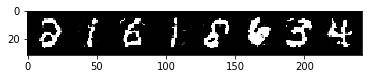

Plotted feature  460


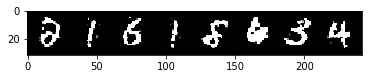

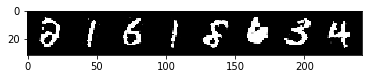

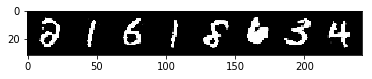

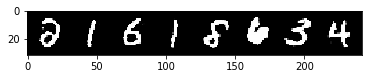

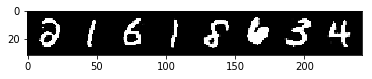

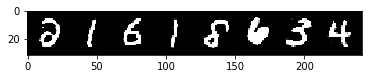

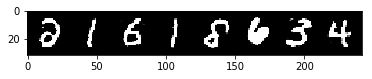

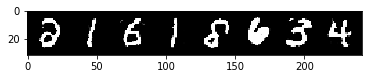

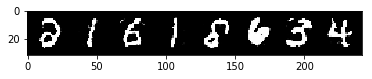

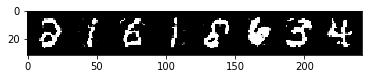

Plotted feature  480


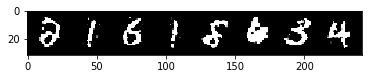

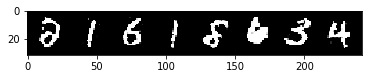

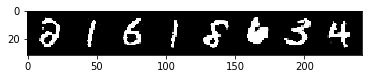

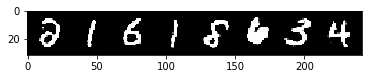

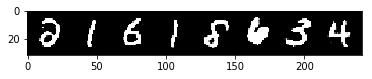

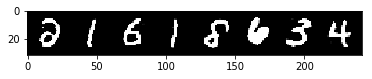

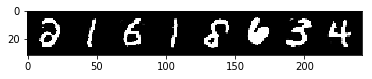

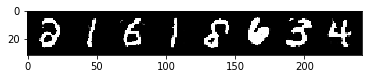

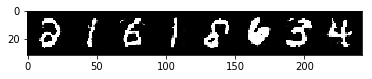

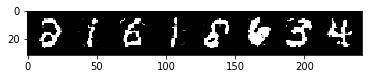

Plotted feature  500


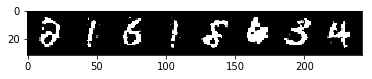

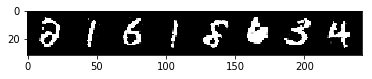

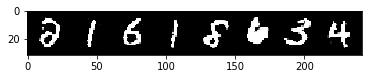

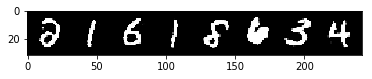

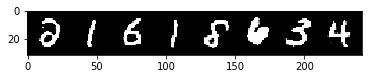

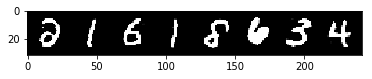

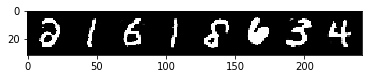

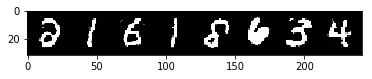

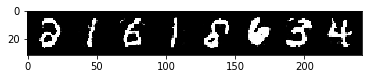

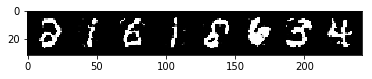

Plotted feature  520


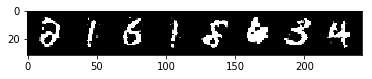

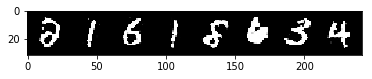

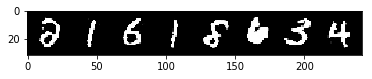

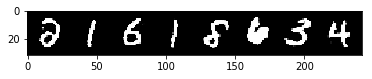

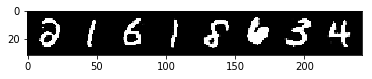

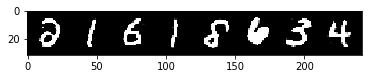

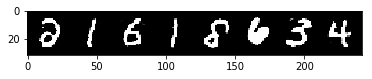

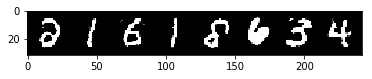

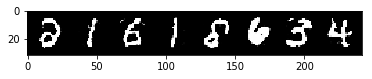

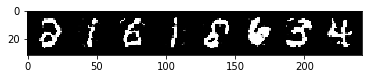

Plotted feature  540


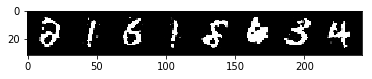

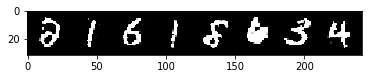

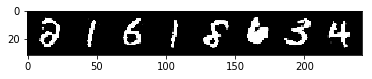

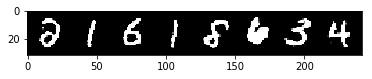

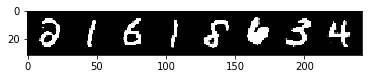

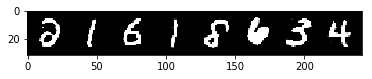

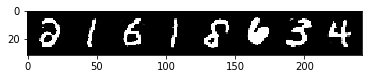

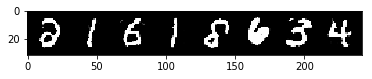

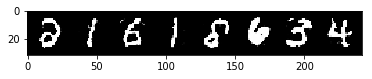

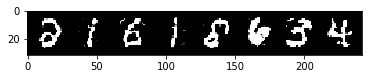

Plotted feature  560


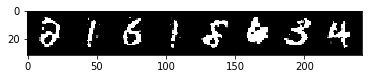

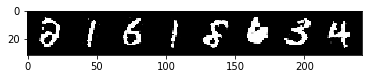

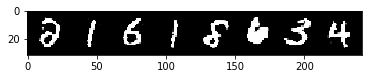

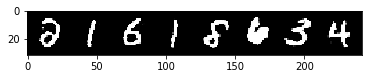

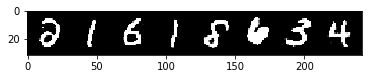

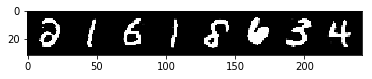

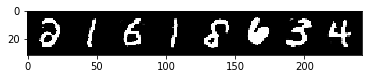

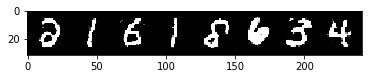

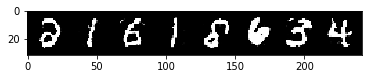

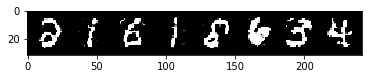

Plotted feature  580


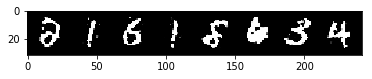

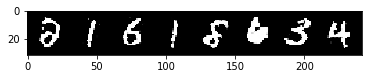

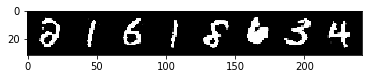

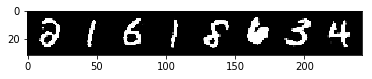

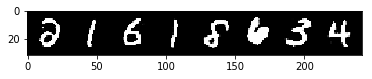

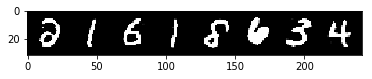

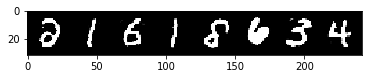

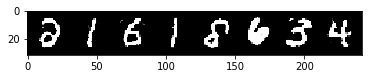

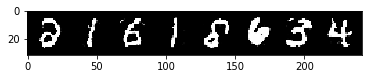

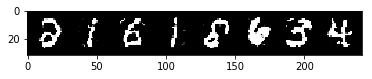

Plotted feature  600


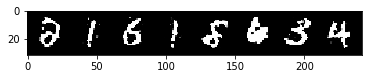

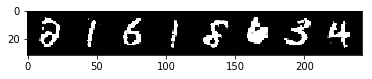

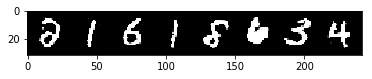

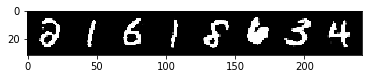

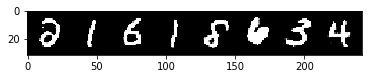

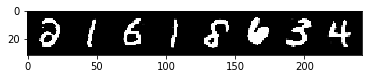

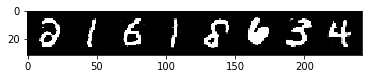

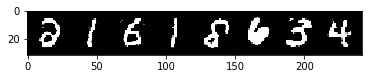

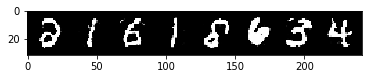

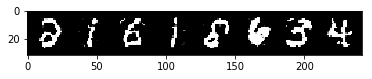

Plotted feature  620


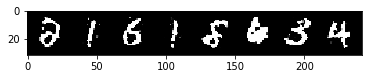

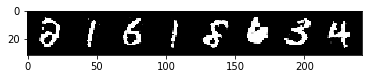

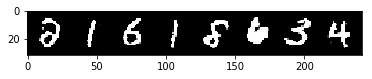

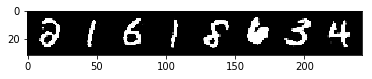

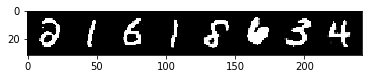

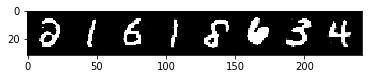

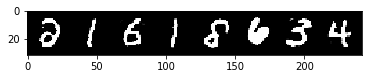

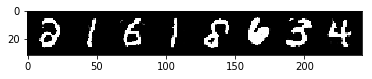

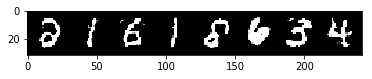

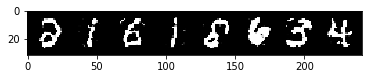

Plotted feature  640


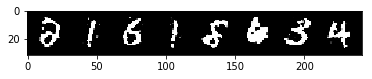

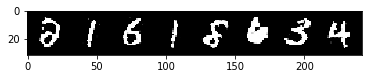

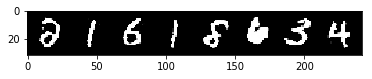

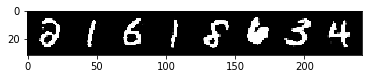

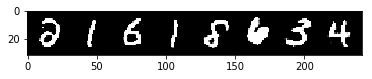

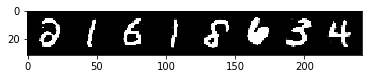

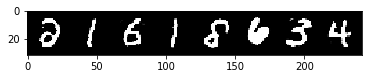

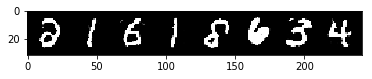

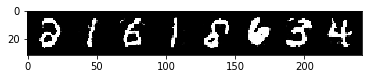

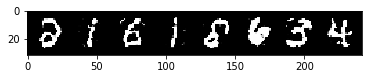

Plotted feature  660


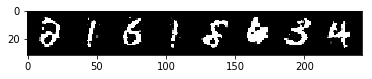

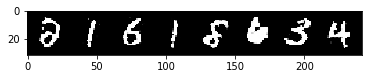

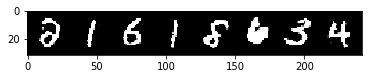

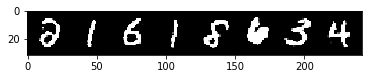

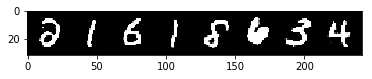

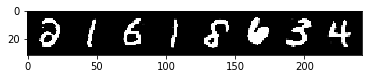

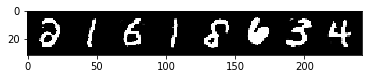

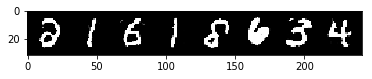

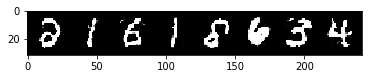

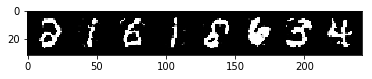

Plotted feature  680


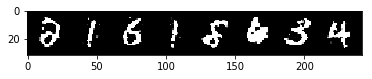

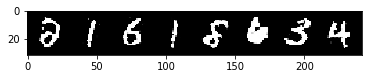

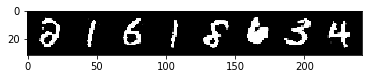

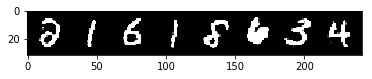

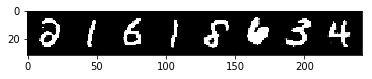

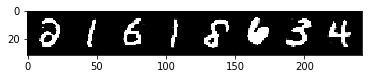

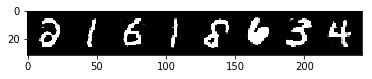

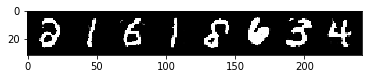

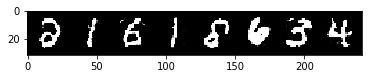

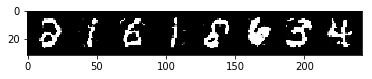

Plotted feature  700


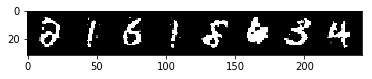

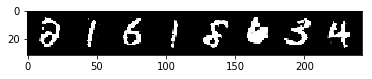

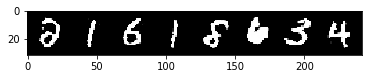

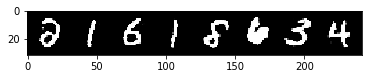

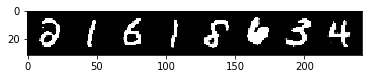

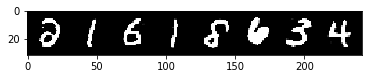

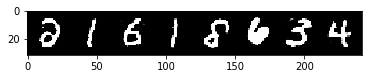

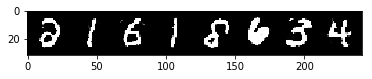

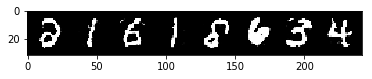

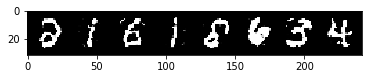

Plotted feature  720


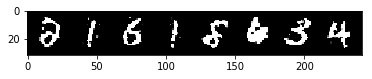

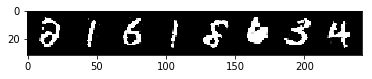

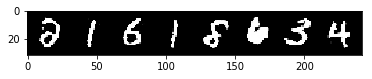

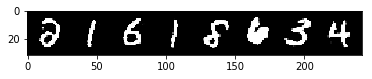

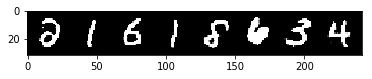

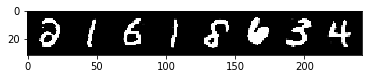

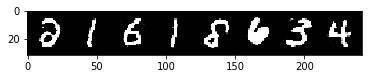

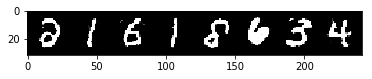

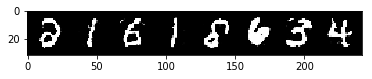

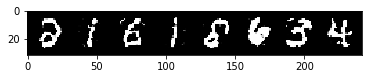

Plotted feature  740


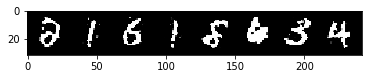

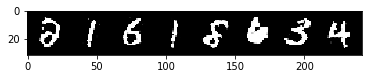

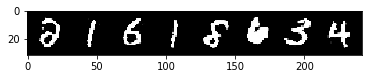

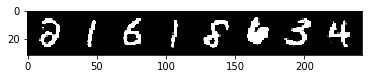

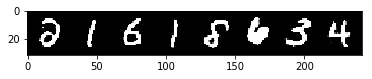

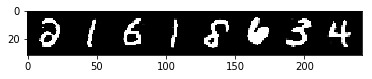

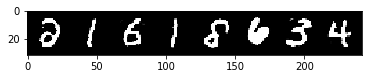

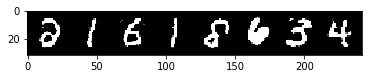

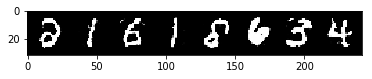

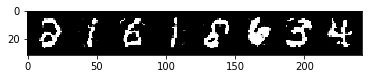

Plotted feature  760


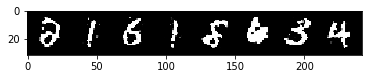

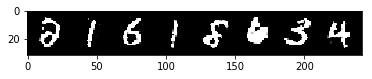

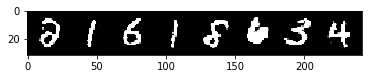

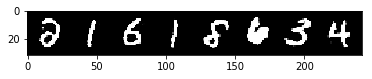

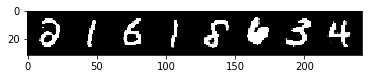

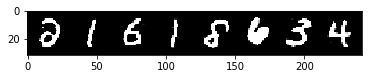

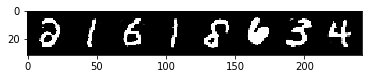

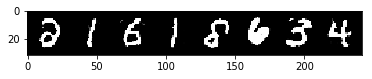

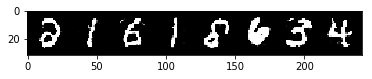

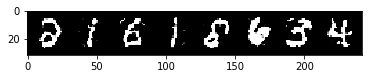

Plotted feature  780


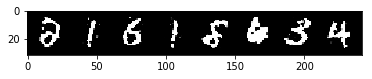

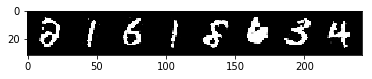

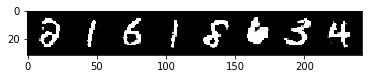

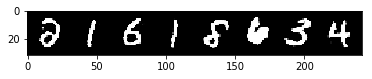

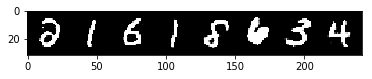

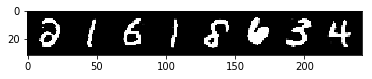

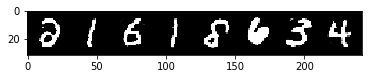

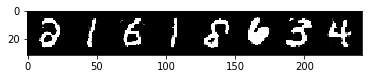

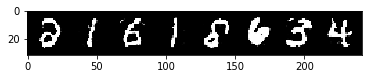

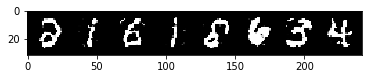

Plotted feature  800


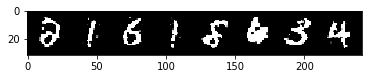

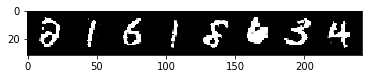

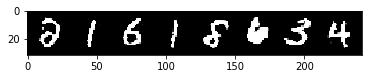

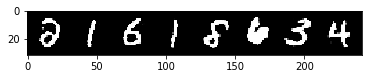

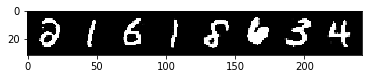

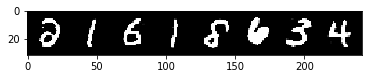

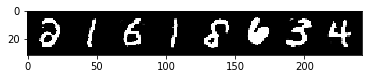

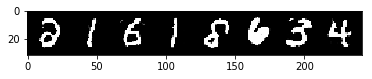

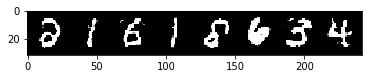

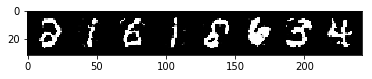

Plotted feature  820


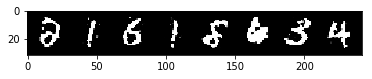

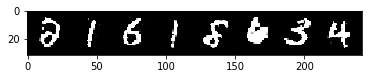

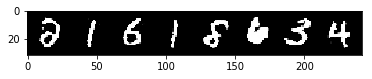

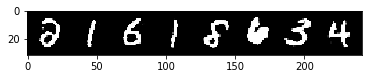

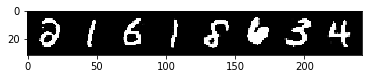

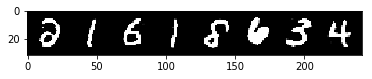

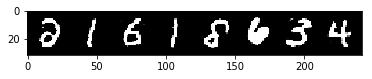

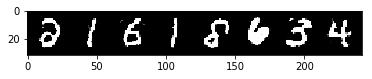

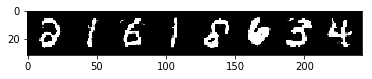

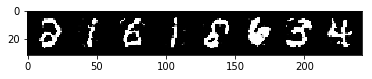

Plotted feature  840


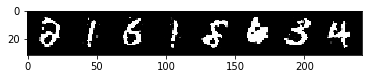

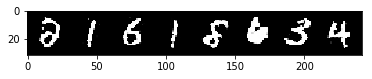

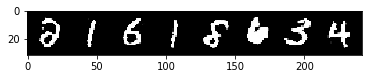

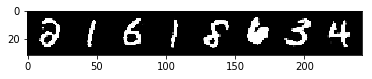

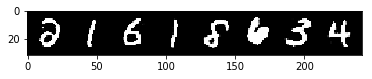

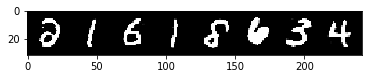

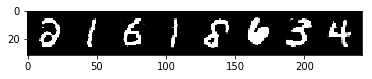

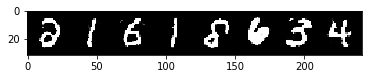

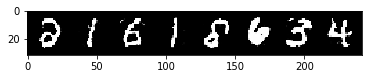

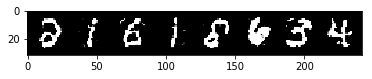

Plotted feature  860


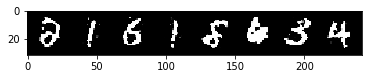

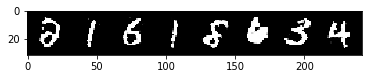

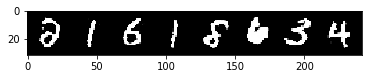

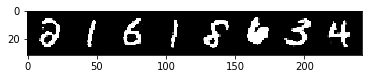

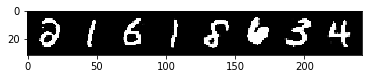

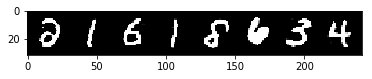

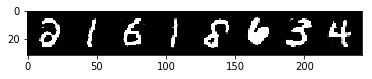

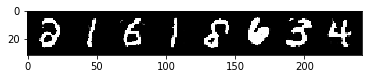

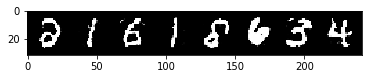

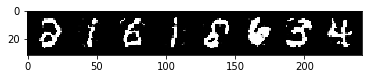

Plotted feature  880


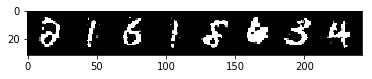

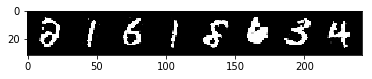

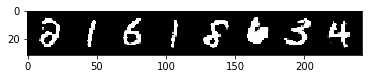

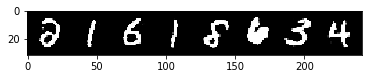

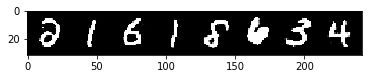

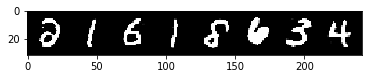

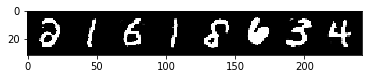

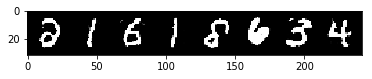

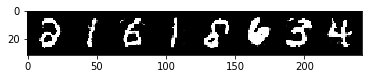

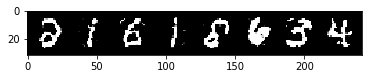

Plotted feature  900


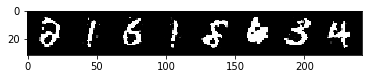

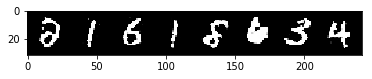

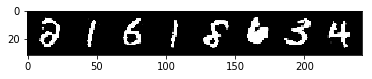

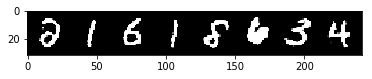

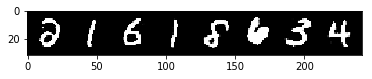

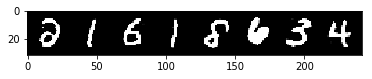

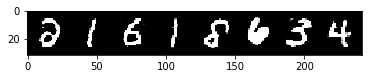

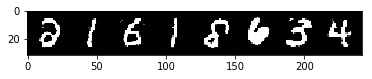

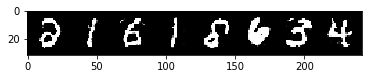

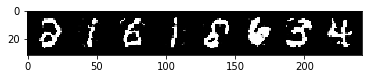

Plotted feature  920


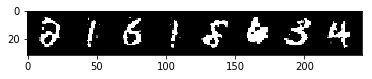

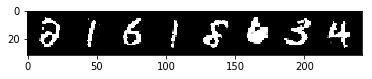

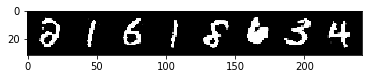

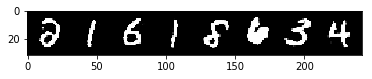

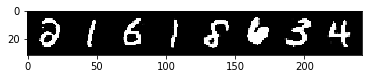

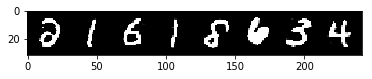

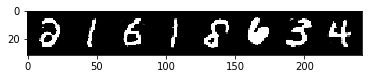

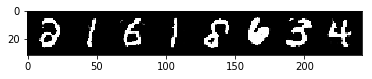

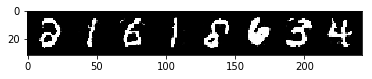

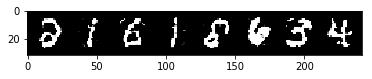

Plotted feature  940


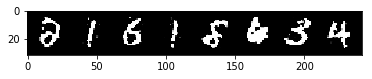

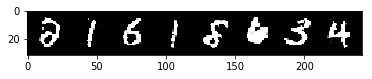

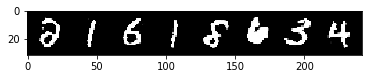

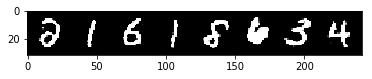

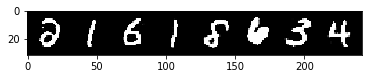

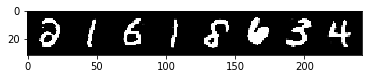

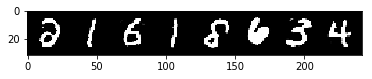

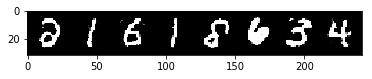

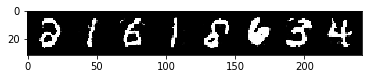

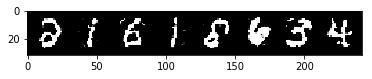

Plotted feature  960


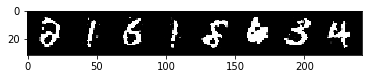

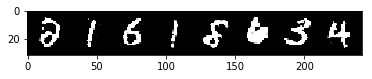

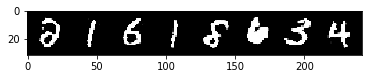

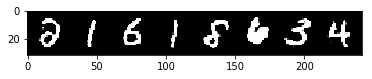

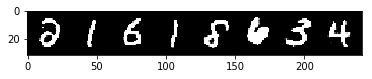

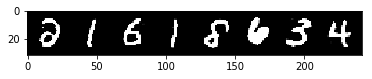

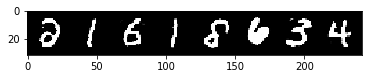

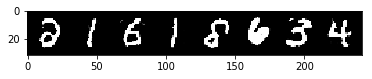

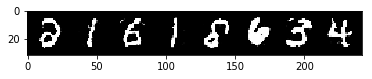

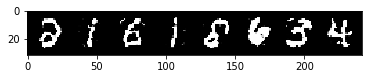

Plotted feature  980


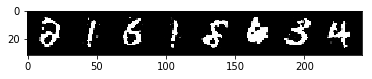

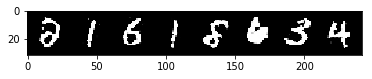

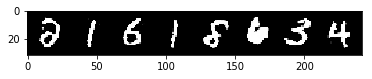

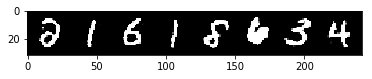

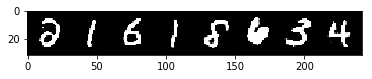

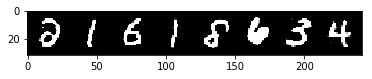

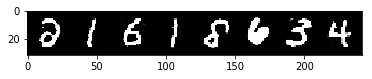

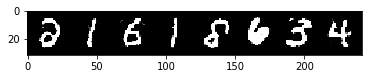

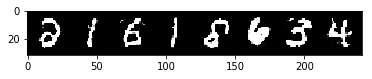

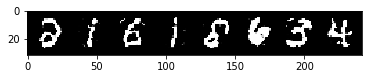

Plotted feature  1000


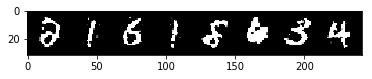

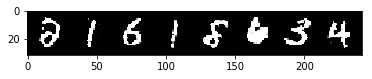

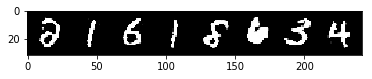

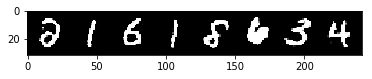

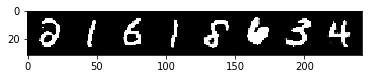

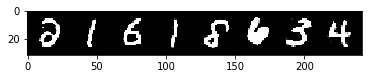

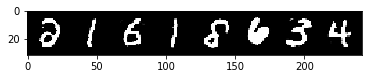

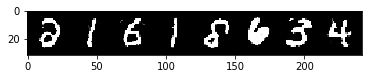

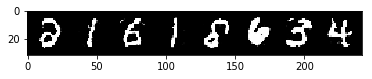

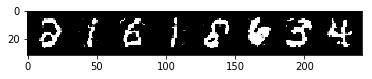

Plotted feature  1020


In [11]:
mnist_net_decoder = Decoder(1024,28*28).cuda()
mnist_net_encoder = Encoder(28*28,1024).cuda()
mnist_net_encoder.load_state_dict(torch.load("mnist_net_enc.mod"))
mnist_net_decoder.load_state_dict(torch.load("mnist_net_dec.mod"))
encodings = get_encodings(mnist_net_encoder,mnist_test,256)
analyse_encoding(mnist_net_decoder,encodings,8)

## Observation
1. A number of features do not seem to have any use as their deviation is very low
2. The encoding is quite robust as the images did not vary much while changing 1 feature at a time 